In [1]:
import cv2
import pytesseract
import re
import os

# Input & output folders
img_folder = "dataset/images/train"
label_folder = "dataset/train/labels_auto"
os.makedirs(label_folder, exist_ok=True)

for img_file in os.listdir(img_folder):
    if not img_file.endswith(".png"):
        continue

    img_path = os.path.join(img_folder, img_file)
    image = cv2.imread(img_path)

    # OCR with bounding boxes
    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

    h, w, _ = image.shape
    yolo_lines = []

    for i, text in enumerate(data["text"]):
        if text.strip() == "":
            continue

        x, y, bw, bh = data["left"][i], data["top"][i], data["width"][i], data["height"][i]

        # Normalize for YOLO format
        x_center = (x + bw / 2) / w
        y_center = (y + bh / 2) / h
        width = bw / w
        height = bh / h

        # Detect class
        if re.match(r"\d{2}/\d{2}/\d{4}", text):   # date
            cls = 1
        elif text.istitle() or text.isupper():     # simple heuristic for name
            cls = 0
        else:
            continue  # skip if not name/date

        yolo_lines.append(f"{cls} {x_center} {y_center} {width} {height}")

    # Save label file
    if yolo_lines:
        txt_path = os.path.join(label_folder, img_file.replace(".png", ".txt"))
        with open(txt_path, "w") as f:
            f.write("\n".join(yolo_lines))


In [3]:
import os

sig_label_folder = "dataset/labels/train"       # existing signature labels
auto_label_folder = "dataset/train/labels_auto" # generated name/date labels
final_label_folder = "dataset/train/labels_final"
os.makedirs(final_label_folder, exist_ok=True)

for file in os.listdir(sig_label_folder):
    if not file.endswith(".txt"):
        continue

    # Read signature labels
    sig_path = os.path.join(sig_label_folder, file)
    with open(sig_path, "r") as f:
        sig_lines = f.readlines()

    # Read auto-generated labels if available
    auto_path = os.path.join(auto_label_folder, file)
    auto_lines = []
    if os.path.exists(auto_path):
        with open(auto_path, "r") as f:
            auto_lines = f.readlines()

    # Merge both
    final_lines = auto_lines + sig_lines

    # Save final labels
    final_path = os.path.join(final_label_folder, file)
    with open(final_path, "w") as f:
        f.writelines(final_lines)

print("✅ All labels merged into labels_final/")


✅ All labels merged into labels_final/


In [6]:
from ultralytics import YOLO

# Load YOLOv8 small model
model = YOLO("yolov8s.pt")

# Train
model.train(
    data="dataset/dataset.yaml",   # path to data.yaml
    epochs=5,
    imgsz=640,
    batch=16
)


New https://pypi.org/project/ultralytics/8.3.199 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.198  Python-3.13.2 torch-2.8.0+cpu CPU (12th Gen Intel Core i5-12500H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, opti

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000167207FA450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

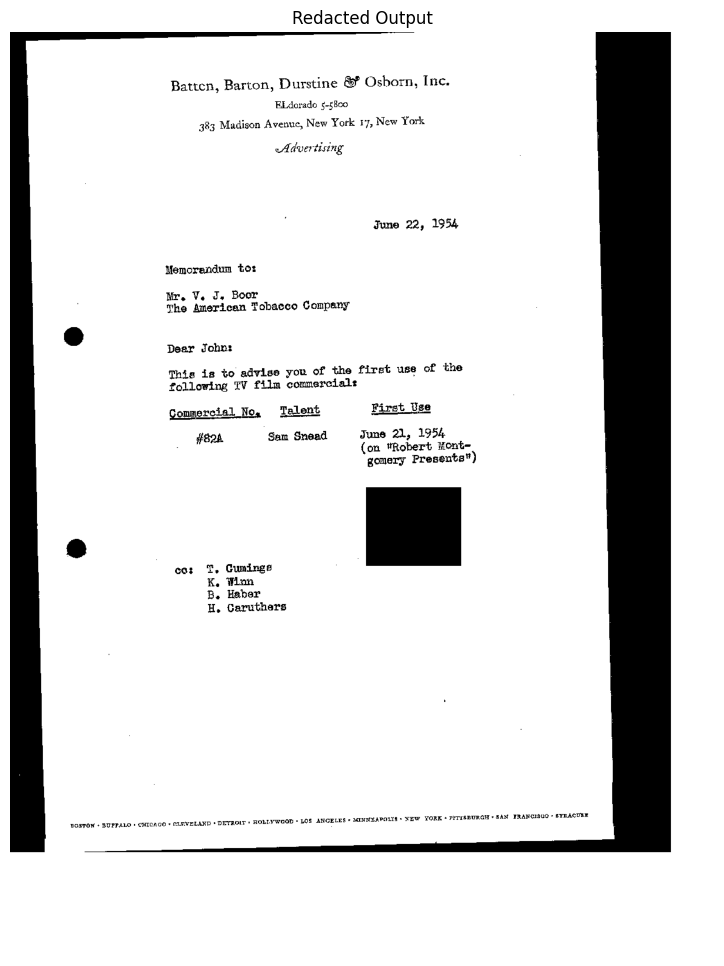

In [9]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load trained model
model = YOLO("runs/detect/train2/weights/best.pt")

# Path to image
image_path = "dataset/images/train/adq65f00.png"

# Run inference (lower conf threshold so weak detections also show up)
results = model.predict(source=image_path, conf=0.15, save=False, verbose=False)

# Load original image
img = cv2.imread(image_path)

# Class mapping (as per your data.yaml)
class_names = ['name', 'date', 'signature', 'redaction']

# Classes you want to redact
redact_classes = ['name', 'date', 'signature']  # leave out "redaction" if it's just helper class

# Iterate over detections
for box in results[0].boxes:
    cls_id = int(box.cls)
    cls_name = class_names[cls_id]

    if cls_name in redact_classes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        
        # Black out the detected region
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), -1)

# Save result
cv2.imwrite("redacted_output.png", img)

# Show the result with matplotlib
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Redacted Output")
plt.show()



image 1/1 C:\Users\Vanitha_V\Downloads\NASSCOM\dataset\images\train\adq65f00.png: 640x512 1 name, 153.1ms
Speed: 4.5ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


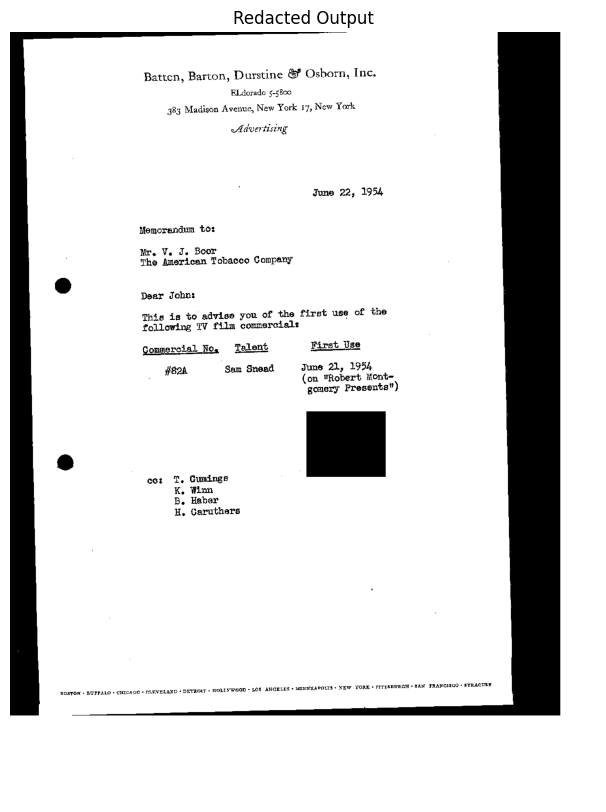

In [6]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load trained model
model = YOLO("runs/detect/train2/weights/best.pt")

# Path to image
image_path = "dataset/images/train/adq65f00.png"

# Run inference
results = model.predict(source=image_path, conf=0.25, save=False)

# Load original image
img = cv2.imread(image_path)

# Classes you want to redact (adjust based on your dataset.yaml order)
redact_classes = [0, 1, 2, 3]  # name, date, signature, etc.

# Iterate over detections
for box in results[0].boxes:
    cls_id = int(box.cls)
    if cls_id in redact_classes:
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        
        # Black out the detected region
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), -1)

# Save result
cv2.imwrite("redacted_output.png", img)

# Show the result with matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Redacted Output")
plt.show()
